# Anomaly Detection

In [1]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

In [2]:
def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

# Discrete data + probability

In [3]:
colnames=['ip', 'timestamp', 'request_method', 'status', 'size',
          'destination', 'request_agent']
df_orig = pd.read_csv('http://python.zach.lol/access.log',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0, 3, 4, 5, 6, 7, 8]
)

new = pd.DataFrame([["95.31.18.119", "[21/Apr/2019:10:02:41+0000]", 
                     "GET /api/v1/items/HTTP/1.1", 200, 1153005, np.nan, 
                     "python-requests/2.21.0"],
                    ["95.31.16.121", "[17/Apr/2019:19:36:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 1005, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.15.120", "[18/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 301, 2560, np.nan, 
                     "python-requests/2.21.0"],
                    ["97.105.19.58", "[19/Apr/2019:19:42:41+0000]", 
                     "GET /api/v1/sales?page=79/HTTP/1.1", 200, 2056327, np.nan, 
                     "python-requests/2.21.0"]], columns=colnames)

df = df_orig.append(new)

In [4]:
df.head()

,ip,timestamp,request_method,status,size,destination,request_agent
0,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
1,97.105.19.58,[16/Apr/2019:19:34:42 +0000],"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2,97.105.19.58,[16/Apr/2019:19:34:44 +0000],"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
3,97.105.19.58,[16/Apr/2019:19:34:46 +0000],"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
4,97.105.19.58,[16/Apr/2019:19:34:48 +0000],"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [5]:
df.timestamp = df.timestamp.str.replace(r'(\[|\])', '', regex=True)

In [6]:
#brackets removed from timestamp
df.timestamp.head()

0    16/Apr/2019:19:34:42 +0000
1    16/Apr/2019:19:34:42 +0000
2    16/Apr/2019:19:34:44 +0000
3    16/Apr/2019:19:34:46 +0000
4    16/Apr/2019:19:34:48 +0000
Name: timestamp, dtype: object

In [7]:
df.timestamp= pd.to_datetime(df.timestamp.str.replace(':', ' ', 1)) 

In [8]:
#removed first instance of ':' on each line and made datetime
df.timestamp.head()

0   2019-04-16 19:34:42
1   2019-04-16 19:34:42
2   2019-04-16 19:34:44
3   2019-04-16 19:34:46
4   2019-04-16 19:34:48
Name: timestamp, dtype: datetime64[ns]

In [9]:
#set timestamp as index
df = df.set_index('timestamp')

In [10]:
df.head()

,ip,request_method,status,size,destination,request_agent
timestamp,,,,,,
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/sales?page=81 HTTP/1.1""",200,512495,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:42,97.105.19.58,"""GET /api/v1/items HTTP/1.1""",200,3561,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:44,97.105.19.58,"""GET /api/v1/sales?page=82 HTTP/1.1""",200,510103,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:46,97.105.19.58,"""GET /api/v1/sales?page=83 HTTP/1.1""",200,510003,NaN,"""python-requests/2.21.0"""
2019-04-16 19:34:48,97.105.19.58,"""GET /api/v1/sales?page=84 HTTP/1.1""",200,511963,NaN,"""python-requests/2.21.0"""


In [11]:
#clean up columns
for col in ['request_method', 'request_agent', 'destination']:
    df[col] = df[col].str.replace('"', '')

In [12]:
df.destination.unique()

array([nan, 'https://python.zach.lol/api/V1/HiZach!',
       'https://python.zach.lol/api/v1/stores?page=0',
       'https://python.zach.lol/api/v1/stores?page=1',
       'https://python.zach.lol/api/v1/stores?page=2',
       'https://python.zach.lol/api/v1/stores?page=999',
       'https://python.zach.lol/api/v1/items?page=0',
       'http://localhost:8889/notebooks/timeseries_acquisition.ipynb',
       'https://python.zach.lol/api/v1//api/v1/items?page=2',
       'https://python.zach.lol/api/v1//api/v1/items',
       'https://python.zach.lol/api/v1//api/v1/items/next_page',
       'https://python.zach.lol/api/v1/helloclass!',
       'https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!',
       'http://localhost:8888/notebooks/acquire.ipynb',
       'https://python.zach.lol/api/v1/sales?page=3',
       'https://ds.codeup.com/8.3_Acquire/', 'https://python.zach.lol/',
       'https://python.zach.lol/api/v1/items',
       'https://python.zach.lol/api/v1/'], dtype=object)

In [13]:
df['destination'] = df.destination.str.replace(r'\?page=[0-9]+', '', regex=True)

In [14]:
df.destination.unique()

array([nan, 'https://python.zach.lol/api/V1/HiZach!',
       'https://python.zach.lol/api/v1/stores',
       'https://python.zach.lol/api/v1/items',
       'http://localhost:8889/notebooks/timeseries_acquisition.ipynb',
       'https://python.zach.lol/api/v1//api/v1/items',
       'https://python.zach.lol/api/v1//api/v1/items/next_page',
       'https://python.zach.lol/api/v1/helloclass!',
       'https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!',
       'http://localhost:8888/notebooks/acquire.ipynb',
       'https://python.zach.lol/api/v1/sales',
       'https://ds.codeup.com/8.3_Acquire/', 'https://python.zach.lol/',
       'https://python.zach.lol/api/v1/'], dtype=object)

In [15]:
#converting bytes to mb
df['size_mb'] = [n/1024/1024 for n in df['size']]

In [16]:
df.head()

,ip,request_method,status,size,destination,request_agent,size_mb
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/sales?page=81 HTTP/1.1,200,512495,NaN,python-requests/2.21.0,0.488753
2019-04-16 19:34:42,97.105.19.58,GET /api/v1/items HTTP/1.1,200,3561,NaN,python-requests/2.21.0,0.003396
2019-04-16 19:34:44,97.105.19.58,GET /api/v1/sales?page=82 HTTP/1.1,200,510103,NaN,python-requests/2.21.0,0.486472
2019-04-16 19:34:46,97.105.19.58,GET /api/v1/sales?page=83 HTTP/1.1,200,510003,NaN,python-requests/2.21.0,0.486377
2019-04-16 19:34:48,97.105.19.58,GET /api/v1/sales?page=84 HTTP/1.1,200,511963,NaN,python-requests/2.21.0,0.488246


### Finding anomalies in already existing data

In [17]:
dest_df = pd.DataFrame(df.destination.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_count'})
dest_df2 = pd.DataFrame(df.destination.value_counts(dropna=False)/df.destination.count()).reset_index().\
                rename(index=str, columns={'index': 'destination', 'destination': 'destination_proba'})
dest_df = dest_df.merge(dest_df2)

In [18]:
dest_df

,destination,destination_count,destination_proba
0,NaN,13953,558.12
1,https://python.zach.lol/api/v1/stores,5,0.20
2,https://python.zach.lol/,4,0.16
3,https://ds.codeup.com/8.3_Acquire/,3,0.12
4,https://python.zach.lol/api/v1/,2,0.08
5,https://python.zach.lol/api/v1//api/v1/items,2,0.08
6,https://python.zach.lol/api/v1/items,2,0.08
7,https://python.zach.lol/api/v1/sales,1,0.04
8,https://python.zach.lol/api/v1/I_DIDNT_DO_IT!!!!,1,0.04
9,https://python.zach.lol/api/v1/helloclass!,1,0.04


In [19]:
ra_df = pd.DataFrame(df.request_agent.value_counts(dropna=False)).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'ra_count'})
ra_df2 = pd.DataFrame(df.request_agent.value_counts(dropna=False)/df.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'ra_proba'})
ra_df = ra_df.merge(ra_df2)

In [20]:
ra_df

,request_agent,ra_count,ra_proba
0,python-requests/2.21.0,12005,0.858850
1,python-requests/2.20.1,1911,0.136715
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


In [21]:
# see those where rate < 1% 
ra_df[ra_df.ra_proba < .01]

,request_agent,ra_count,ra_proba
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,34,0.002432
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,8,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,7,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),6,0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,4,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,2,0.000143
8,Python-urllib/3.7,1,0.000072


9
                                       request_agent  ra_count  ra_proba
0                             python-requests/2.21.0     12005  0.858850
1                             python-requests/2.20.1      1911  0.136715
2  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...        34  0.002432
3  Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...         8  0.000572
4  Slackbot-LinkExpanding 1.0 (+https://api.slack...         7  0.000501
5       Slackbot 1.0 (+https://api.slack.com/robots)         6  0.000429
6  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...         4  0.000286
7  Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...         2  0.000143
8                                  Python-urllib/3.7         1  0.000072


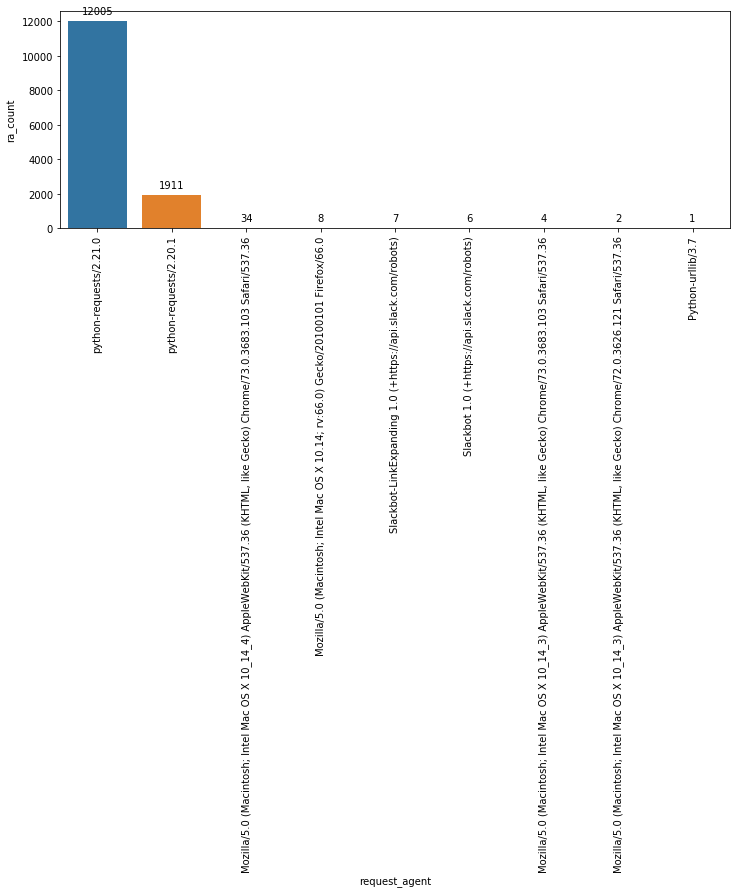

In [22]:
print(len(ra_df))

print(ra_df.tail(10))

plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ra_df, x = 'request_agent', y = 'ra_count', ci = None)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), 
                   textcoords = 'offset points'
                   )
    plt.xticks(rotation='vertical')

### Detecting anomalies by establishing a baseline and evaluate as new data arrives

In [23]:
#baseline
train = df['2019-04-16 19:34:42':'2019-04-17 12:55:14'][['ip','request_method','status','size','destination','request_agent','size_mb']]



In [24]:
#compute probabilities based on train sample
ra_df = pd.DataFrame(train.request_agent.value_counts(dropna=False)/train.request_agent.count()).reset_index().\
                rename(index=str, columns={'index': 'request_agent', 'request_agent': 'ra_proba'})

In [25]:
ra_df

,request_agent,ra_proba
0,python-requests/2.21.0,0.858809
1,python-requests/2.20.1,0.136754
2,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...,0.002433
3,Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; ...,0.000572
4,Slackbot-LinkExpanding 1.0 (+https://api.slack...,0.000501
5,Slackbot 1.0 (+https://api.slack.com/robots),0.000429
6,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000286
7,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3...,0.000143
8,Python-urllib/3.7,0.000072


In [26]:
#Merge probabilities with all data (train + new data)
#Where the request_agent is new, i.e. not seen in the training dataset, fill the probability with a value of 0.

df = df.reset_index().merge(ra_df, on=['request_agent'], how='left').fillna(value=0).set_index('timestamp')
df.ra_proba.value_counts()

0.858809    12005
0.136754     1911
0.002433       34
0.000572        8
0.000501        7
0.000429        6
0.000286        4
0.000143        2
0.000072        1
Name: ra_proba, dtype: int64

# Time series + EMA

In [27]:
#read file in
with open('./anonymized-curriculum-access.txt') as f:
    contents = f.read()

In [28]:
# contents

In [29]:
lines = contents.split('\n')

In [30]:
line = lines[2]

In [31]:
line

'2018-01-26 09:56:05 java-ii/object-oriented-programming 1 8 97.105.19.61'

In [32]:
line.split(' ')

['2018-01-26',
 '09:56:05',
 'java-ii/object-oriented-programming',
 '1',
 '8',
 '97.105.19.61']

In [33]:
def process_line(lines: str):
    parts = line.split(' ')
    for i, part in enumerate(parts):
        print(i, part)

In [34]:
process_line(lines[0])

0 2018-01-26
1 09:56:05
2 java-ii/object-oriented-programming
3 1
4 8
5 97.105.19.61


In [35]:
def process_line(line: str):
    parts = line.split(' ')

    link = parts[2]
    
    timestamp = parts[0] + ' ' + parts[1]

    student_id = parts[3]

    cohort_id= parts[4]
    
    ip = parts[5]

    return dict(ip=ip, timestamp=timestamp,
                student_id=student_id,
               cohort_id=cohort_id,
               link=link)

In [36]:
process_line(lines[0])

{'ip': '97.105.19.61',
 'timestamp': '2018-01-26 09:55:03',
 'student_id': '1',
 'cohort_id': '8',
 'link': '/'}

In [37]:
lines = lines[:-1]

In [38]:
lines[0]

'2018-01-26 09:55:03 / 1 8 97.105.19.61'

In [39]:
processed_lines = []
for line in lines:
    processed_lines.append(process_line(line))

In [40]:
processed_lines[0]

{'ip': '97.105.19.61',
 'timestamp': '2018-01-26 09:55:03',
 'student_id': '1',
 'cohort_id': '8',
 'link': '/'}

In [64]:
df = pd.DataFrame(processed_lines)
df.head()

,cohort_id,ip,link,student_id,timestamp
0,8,97.105.19.61,/,1,2018-01-26 09:55:03
1,8,97.105.19.61,java-ii,1,2018-01-26 09:56:02
2,8,97.105.19.61,java-ii/object-oriented-programming,1,2018-01-26 09:56:05
3,8,97.105.19.61,slides/object_oriented_programming,1,2018-01-26 09:56:06
4,22,97.105.19.61,javascript-i/conditionals,2,2018-01-26 09:56:24


In [42]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)

In [43]:
df.set_index('timestamp', inplace=True)

In [63]:
df.head()

,cohort_id,ip,link,student_id
timestamp,,,,
2018-01-26 09:55:03+00:00,8,97.105.19.61,/,1
2018-01-26 09:56:02+00:00,8,97.105.19.61,java-ii,1
2018-01-26 09:56:05+00:00,8,97.105.19.61,java-ii/object-oriented-programming,1
2018-01-26 09:56:06+00:00,8,97.105.19.61,slides/object_oriented_programming,1
2018-01-26 09:56:24+00:00,22,97.105.19.61,javascript-i/conditionals,2


In [45]:
df.cohort_id.nunique()

28

In [46]:
df.student_id.nunique()

398

In [47]:
df.describe()

,cohort_id,ip,link,student_id
count,233528,233528,233528,233528
unique,28,1731,999,398
top,24,97.105.19.58,/,53
freq,34485,105645,12041,5839


In [48]:
df.head()

,cohort_id,ip,link,student_id
timestamp,,,,
2018-01-26 09:55:03+00:00,8,97.105.19.61,/,1
2018-01-26 09:56:02+00:00,8,97.105.19.61,java-ii,1
2018-01-26 09:56:05+00:00,8,97.105.19.61,java-ii/object-oriented-programming,1
2018-01-26 09:56:06+00:00,8,97.105.19.61,slides/object_oriented_programming,1
2018-01-26 09:56:24+00:00,22,97.105.19.61,javascript-i/conditionals,2


In [49]:
# df.cohort_id = df.cohort_id.values.astype('int')

In [50]:
df.dtypes

cohort_id     object
ip            object
link          object
student_id    object
dtype: object

In [51]:
cohorts = pd.read_csv('cohorts.csv')

In [52]:
cohorts.rename(columns={'id':'cohort_id'}, inplace=True)

In [53]:
cohorts.head()

,cohort_id,name,start_date,end_date
0,1,Arches,2014-02-04,2014-04-22
1,2,Badlands,2014-06-04,2014-08-22
2,3,Carlsbad,2014-09-04,2014-11-05
3,4,Denali,2014-10-20,2015-01-18
4,5,Everglades,2014-11-18,2015-02-24


In [54]:
cohorts.dtypes

cohort_id      int64
name          object
start_date    object
end_date      object
dtype: object

In [55]:
cohorts.cohort_id = cohorts.cohort_id.astype('str')

In [56]:
cohorts.dtypes

cohort_id     object
name          object
start_date    object
end_date      object
dtype: object

In [57]:
df_merged = df.merge(cohorts, on='cohort_id', how='left')
df_merged.head()

,cohort_id,ip,link,student_id,name,start_date,end_date
0,8,97.105.19.61,/,1,Hampton,2015-09-22,2016-02-06
1,8,97.105.19.61,java-ii,1,Hampton,2015-09-22,2016-02-06
2,8,97.105.19.61,java-ii/object-oriented-programming,1,Hampton,2015-09-22,2016-02-06
3,8,97.105.19.61,slides/object_oriented_programming,1,Hampton,2015-09-22,2016-02-06
4,22,97.105.19.61,javascript-i/conditionals,2,Teddy,2018-01-08,2018-05-17


In [58]:
df_agg = df_merged.groupby(['cohort_id','name'])['student_id'].\
                        nunique()

In [59]:
df_agg

cohort_id  name     
1          Arches       17
11         Ike           4
12         Joshua        4
13         Kings        10
14         Lassen       10
15         Mammoth       4
16         Niagara       8
17         Olympic      10
18         Pinnacles    13
19         Quincy       13
2          Badlands      3
21         Sequoia      27
22         Teddy        34
23         Ulysses      33
24         Voyageurs    33
25         Wrangell     26
26         Xanadu       20
27         Yosemite     27
28         Staff        12
29         Zion         25
31         Andromeda    23
4          Denali        1
6          Franklin      1
7          Glacier       5
8          Hampton       4
9          Apollo        1
Name: student_id, dtype: int64

In [61]:
staff = df[df.cohort_id == '28']

In [62]:
staff.student_id.value_counts()

11     1525
1      1022
64     1001
314     704
248     600
211     563
53      321
312     131
146     102
397      74
40       66
370      54
Name: student_id, dtype: int64

In [65]:
df_25 = df[df.cohort_id == '25']

In [66]:
df_25.describe()

,cohort_id,ip,link,student_id,timestamp
count,24681,24681,24681,24681,24681
unique,1,391,389,26,24282
top,25,97.105.19.58,/,234,2018-10-30 13:52:18
freq,24681,17394,1040,1696,5


In [104]:
df_25.index.max()

230051

In [106]:
df_25['timestamp'] = pd.to_datetime(df_25['timestamp'], utc=True)

In [107]:
df_25.set_index('timestamp', inplace=True)

In [70]:
#start date: 2018-07-23

In [108]:
df_25.link.value_counts().tail(126)

slides/sessions_and_cookies                           1
8._Time_Series                                        1
10._NLP                                               1
prework/cli/03-file-paths                             1
6.04.01_Preprocessing                                 1
2.01.00_Descriptive_Stats                             1
10.02.01_ParseText                                    1
4.6.3_introduction_to_pandas                          1
8.03_Explore                                          1
content/php_ii/command-line/io-streams.html           1
5.02_Prep                                             1
slides/deployment_and_dependencies                    1
6.01.01_AcquireSQL                                    1
2.02.00_Inferential_Stats                             1
2.02.06_Correlation                                   1
4.6.2_introduction_to_numpy                           1
10.00_Intro.html                                      1
13.03_Bokeh                                     

In [109]:
my_datetime_fmt = mdates.DateFormatter('%m-%d %H:%T')

df_student = df_25['student_id'].resample('W').count()

df_student = df_student.fillna(value=0)

In [110]:
df_student = df_student.astype(str)

In [111]:
df_student

timestamp
2018-07-29 00:00:00+00:00    1704
2018-08-05 00:00:00+00:00    1649
2018-08-12 00:00:00+00:00    1683
2018-08-19 00:00:00+00:00    1969
2018-08-26 00:00:00+00:00    1428
2018-09-02 00:00:00+00:00    2028
2018-09-09 00:00:00+00:00    1440
2018-09-16 00:00:00+00:00    1660
2018-09-23 00:00:00+00:00    1438
2018-09-30 00:00:00+00:00    1248
2018-10-07 00:00:00+00:00    1853
2018-10-14 00:00:00+00:00    1647
2018-10-21 00:00:00+00:00    1138
2018-10-28 00:00:00+00:00     883
2018-11-04 00:00:00+00:00     944
2018-11-11 00:00:00+00:00     765
2018-11-18 00:00:00+00:00     297
2018-11-25 00:00:00+00:00     113
2018-12-02 00:00:00+00:00     250
2018-12-09 00:00:00+00:00      78
2018-12-16 00:00:00+00:00      19
2018-12-23 00:00:00+00:00      12
2018-12-30 00:00:00+00:00       0
2019-01-06 00:00:00+00:00      71
2019-01-13 00:00:00+00:00       0
2019-01-20 00:00:00+00:00      25
2019-01-27 00:00:00+00:00      17
2019-02-03 00:00:00+00:00      16
2019-02-10 00:00:00+00:00      17
2019

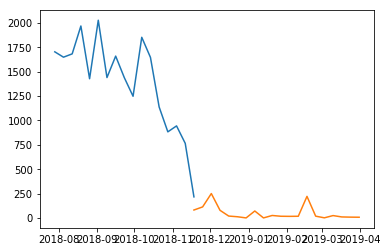

In [115]:
train = df_25[:'2018-11-15']['student_id'].resample('W').agg('count')
test = df_25['2018-11-16':]['student_id'].resample('W').agg('count')
plt.plot(train)
plt.plot(test)

In [116]:
#SIMPLE MOVING AVERAGE
# Calculating the short-window simple moving average
short_rolling = train.rolling(4).mean()

# Calculating the long-window simple moving average
long_rolling = train.rolling(8).mean()

Text(0, 0.5, 'id total')

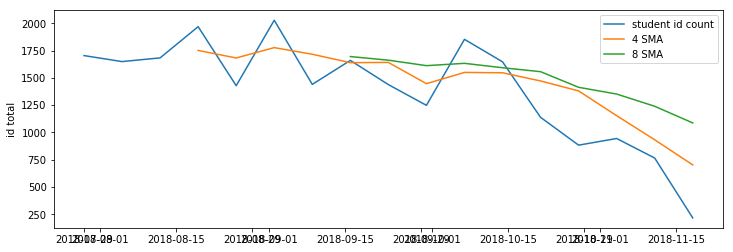

In [117]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='student id count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '4 SMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '8 SMA')

ax.legend(loc='best')
ax.set_ylabel('id total')
# ax.xaxis(rotate=90)
# ax.xaxis.set_major_formatter(my_datetime_fmt)

In [118]:
#EMA
ema_short = train.ewm(span=12, adjust=False).mean()
ema_short[0:3]

ema_long = train.ewm(span=12, adjust=False).mean()
ema_long[0:3]

timestamp
2018-07-29 00:00:00+00:00    1704.000000
2018-08-05 00:00:00+00:00    1695.538462
2018-08-12 00:00:00+00:00    1693.609467
Freq: W-SUN, Name: student_id, dtype: float64

In [119]:
span = 24
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

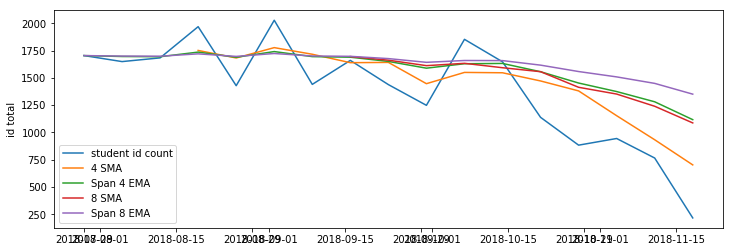

In [120]:
fig, ax = plt.subplots(figsize=(12,4))

ax.plot(train.index, 
        train,
        label='student id count')

ax.plot(short_rolling.index, 
        short_rolling, 
        label = '4 SMA')
ax.plot(long_rolling.index, 
        ema_short, 
        label = 'Span 4 EMA')
ax.plot(long_rolling.index, 
        long_rolling, 
        label = '8 SMA')
ax.plot(long_rolling.index, 
        ema_long, 
        label = 'Span 8 EMA')

ax.legend(loc='best')
ax.set_ylabel('id total')

yhat = pd.DataFrame(dict(actual=test))

In [121]:
span = 7
ema_long = train.ewm(span=span, adjust=False).mean()
midband = ema_long[-1]
ub = midband + ema_long[-24:-1].std()*3
lb = midband - ema_long[-24:-1].std()*3

yhat['moving_avg_forecast'] = midband

In [122]:
yhat = yhat.astype(float)

In [123]:
yhat.dtypes

actual                 float64
moving_avg_forecast    float64
dtype: object

In [124]:
yhat.head()

,actual,moving_avg_forecast
timestamp,,
2018-11-18 00:00:00+00:00,81.0,897.063989
2018-11-25 00:00:00+00:00,113.0,897.063989
2018-12-02 00:00:00+00:00,250.0,897.063989
2018-12-09 00:00:00+00:00,78.0,897.063989
2018-12-16 00:00:00+00:00,19.0,897.063989


In [125]:
# compute the absolute error:
yhat['error'] = abs(yhat.actual - yhat.moving_avg_forecast)

# compute the mean of the absolute error:
# yhat.error.median()

# compute upper band and lower band using IQR with weight of 3

yhat['pct_b'] = (yhat.actual-lb)/(ub-lb)

In [126]:
yhat[yhat.pct_b < 0]
yhat[yhat.pct_b > 1]

,actual,moving_avg_forecast,error,pct_b
timestamp,,,,


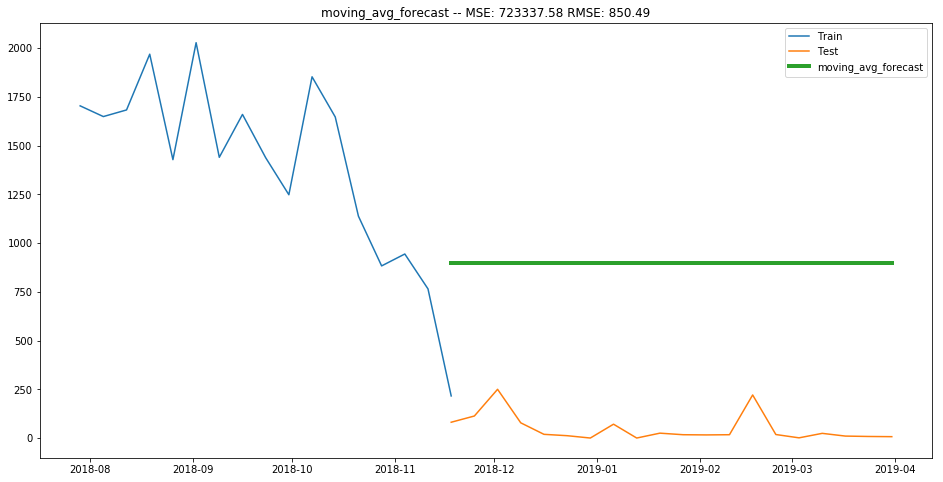

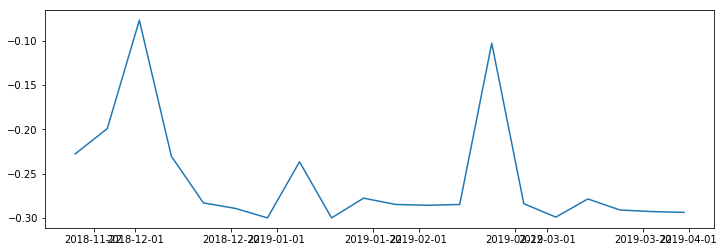

In [127]:
plot_and_eval(yhat.moving_avg_forecast, actual=test)
plt.figure(figsize=(12,4))
plt.plot(yhat.pct_b)

# Clustering - DBSCAN

Use dbscan to detect anomalies in other products from the customers dataset.

Use dbscan to detect anomalies in number of bedrooms and finished square feet of property for the filtered dataset you used in the clustering project (single unit properties with a logerror).

In [128]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [129]:
df = pd.read_csv("customers.csv")

df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [130]:
df = df[["Fresh", "Frozen","Delicassen"]]

In [131]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[12669.,   214.,  1338.],
       [ 7057.,  1762.,  1776.],
       [ 6353.,  2405.,  7844.],
       [13265.,  6404.,  1788.],
       [22615.,  3915.,  5185.],
       [ 9413.,   666.,  1451.],
       [12126.,   480.,   545.],
       [ 7579.,  1669.,  2566.],
       [ 5963.,   425.,   750.],
       [ 6006.,  1159.,  2098.]], dtype=float32)

Normalize each attribute by scaling it to 0 mean and unit variance. This helps to keep the inter-relationships between the features intact so that a small change in one feature would reflect in the other.

In [132]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[ 0.05293319, -0.5893672 , -0.06633906],
       [-0.39130196, -0.27013618,  0.08915105],
       [-0.44702926, -0.13753572,  2.2432926 ],
       [ 0.1001114 ,  0.68714434,  0.09341105],
       [ 0.8402394 ,  0.17385884,  1.2993469 ],
       [-0.20480551, -0.49615505, -0.02622403],
       [ 0.00995035, -0.5345123 , -0.34785426],
       [-0.34998146, -0.28931478,  0.36960125],
       [-0.4779009 , -0.54585445, -0.27507922],
       [-0.4744971 , -0.3944878 ,  0.20346113]], dtype=float32)

In [133]:
#create & fit
dbsc = DBSCAN(eps = .75, min_samples = 15).fit(np_array)

In [134]:
labels = dbsc.labels_
labels[0:10]

array([ 0,  0, -1,  0,  0,  0,  0,  0,  0,  0])

In [135]:
df['labels'] = labels
df.labels.value_counts()

 0    399
-1     41
Name: labels, dtype: int64

In [136]:
df[df.labels==-1].head()

,Fresh,Frozen,Delicassen,labels
2,6353,2405,7844,-1
22,31276,9408,4334,-1
23,26373,5154,16523,-1
24,22647,2915,5778,-1
29,43088,1200,823,-1


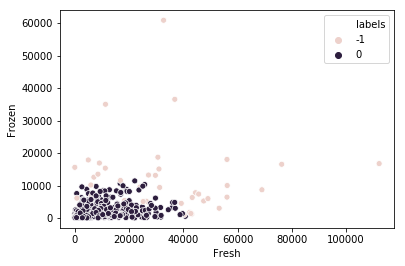

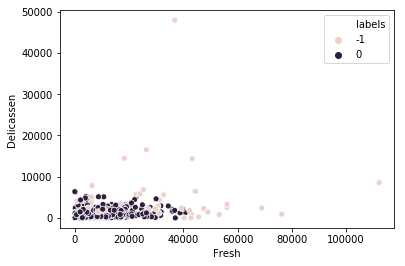

In [137]:
sns.scatterplot(df.Fresh, df.Frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.Fresh, df.Delicassen, hue=df.labels)
plt.show()

Text(0.5, 0, 'Delicassen')

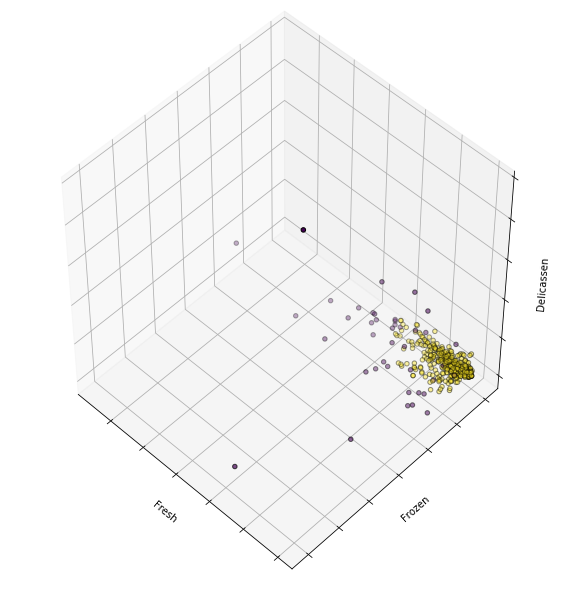

In [138]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(df.Fresh, df.Frozen, df.Delicassen,
           c=df.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Fresh')
ax.set_ylabel('Frozen')
ax.set_zlabel('Delicassen')

### Using zillow data:

In [163]:
df = pd.read_csv("zillow.csv")

In [164]:
df.head().T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
id,2931667,475764,2444575,1584730,2926916
parcelid,11016594,14366692,12098116,12643413,14432541
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2,2.5
bedroomcnt,3,4,2,2,4
calculatedbathnbr,2,3.5,3,2,2.5
finishedfloor1squarefeet,NaN,NaN,NaN,NaN,NaN
calculatedfinishedsquarefeet,1684,2263,2217,839,2283
finishedsquarefeet12,1684,2263,2217,839,2283


In [165]:
df = df[["bathroomcnt", "calculatedfinishedsquarefeet"]]

In [166]:
df.calculatedfinishedsquarefeet.dropna(inplace=True)

In [167]:
df.bathroomcnt.dropna(inplace=True)

In [197]:
df = df[df.bathroomcnt > 0]

In [198]:
df = df[df.calculatedfinishedsquarefeet > 500]

In [199]:
df.calculatedfinishedsquarefeet.isna().sum()

0

In [200]:
df.describe()

,bathroomcnt,calculatedfinishedsquarefeet
count,165599.000000,165599.000000
mean,2.316210,1778.272773
std,0.975704,930.984372
min,1.000000,501.000000
25%,2.000000,1185.000000
50%,2.000000,1541.000000
75%,3.000000,2100.000000
max,18.000000,22741.000000


In [201]:
df.dtypes

bathroomcnt                     float64
calculatedfinishedsquarefeet    float64
dtype: object

In [202]:
df_sample1 = df.head(50000)

In [203]:
np_array = df.values
np_array[0:10]

array([[2.000e+00, 1.684e+03],
       [3.500e+00, 2.263e+03],
       [3.000e+00, 2.217e+03],
       [2.000e+00, 8.390e+02],
       [2.500e+00, 2.283e+03],
       [4.000e+00, 3.067e+03],
       [1.000e+00, 1.297e+03],
       [2.500e+00, 1.763e+03],
       [1.000e+00, 7.960e+02],
       [2.000e+00, 1.260e+03]])

In [204]:
stscaler = StandardScaler().fit(np_array)
np_array = stscaler.transform(np_array)
np_array[0:10]

array([[-0.32408457, -0.1012617 ],
       [ 1.21327164,  0.52066254],
       [ 0.70081957,  0.47125233],
       [-0.32408457, -1.00890588],
       [ 0.1883675 ,  0.54214524],
       [ 1.72572371,  1.38426719],
       [-1.34898871, -0.51695199],
       [ 0.1883675 , -0.01640502],
       [-1.34898871, -1.05509369],
       [-0.32408457, -0.55669499]])

In [205]:
#remove entire row from numpy array where nans are present
np_array = np_array[~np.isnan(np_array).any(axis=1)]

In [206]:
np_sample1 = np_array[0:50000]

In [214]:
dbsc = DBSCAN(eps = 1, min_samples = 10).fit(np_sample1)

In [215]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [216]:
df_sample1['labels'] = labels
df_sample1.labels.value_counts()

 0    49951
-1       49
Name: labels, dtype: int64

In [217]:
df_sample1[df_sample1.labels==-1].head()

,bathroomcnt,calculatedfinishedsquarefeet,labels
163,9.0,7255.0,-1
1352,6.0,10475.0,-1
1707,9.0,16814.0,-1
1963,8.0,10680.0,-1
1973,9.0,4545.0,-1


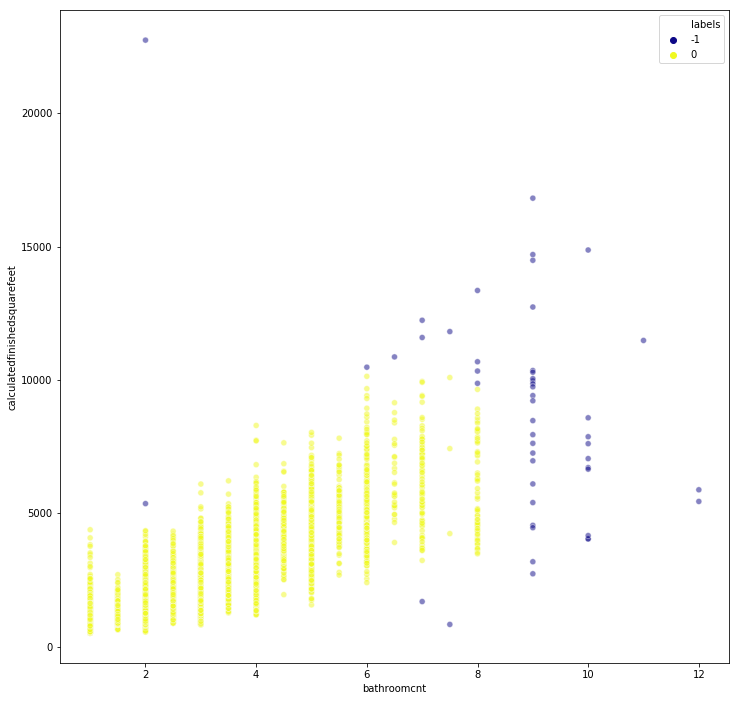

In [218]:
fig = plt.figure(figsize=(12,12))
sns.scatterplot(df_sample1.bathroomcnt, df_sample1.calculatedfinishedsquarefeet, hue=df_sample1.labels, palette='plasma', alpha=.5)
plt.show()